# Distributional Counterfactual Explanation

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

## Read and Process Data

In [30]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()
target_name = 'is_canceled'
target = df[target_name]

In [31]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,14.0,179.0,0,2,0.0,0,0,1,15
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,14.0,179.0,0,2,0.0,0,0,1,15
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,14.0,179.0,0,2,75.0,0,0,1,46
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,179.0,0,2,75.0,0,0,1,46
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,98.0,0,1,1,76


In [32]:
df.drop(target_name, axis=1).values

array([[1.000e+00, 3.420e+02, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        1.500e+01],
       [1.000e+00, 7.370e+02, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        1.500e+01],
       [1.000e+00, 7.000e+00, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        4.600e+01],
       ...,
       [0.000e+00, 3.400e+01, 2.017e+03, ..., 4.000e+00, 1.000e+00,
        2.080e+02],
       [0.000e+00, 1.090e+02, 2.017e+03, ..., 0.000e+00, 1.000e+00,
        2.080e+02],
       [0.000e+00, 2.050e+02, 2.017e+03, ..., 2.000e+00, 1.000e+00,
        2.080e+02]])

## Model Training

In [33]:
features = [
    'hotel', 
    'lead_time', 
    'arrival_date_year', 
    'arrival_date_month',
    'arrival_date_week_number', 
    'arrival_date_day_of_month',
    'stays_in_weekend_nights', 
    'stays_in_week_nights', 
    'adults', 
    'children',
    'babies', 
    'meal', 
    'country', 
    'market_segment', 
    'distribution_channel',
    'is_repeated_guest', 
    'previous_cancellations',
    'previous_bookings_not_canceled', 
    'reserved_room_type',
    'assigned_room_type', 
    'booking_changes', 
    'deposit_type', 
    'agent',
    'company', 
    'days_in_waiting_list', 
    'customer_type', 
    'adr',
    'required_car_parking_spaces', 
    'total_of_special_requests'
]

df_X = df[features].copy()
df_y = target

In [34]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.8304715752601624

## Counterfactual Explanation

In [237]:
sample_num = 100
delta = 0.1
alpha = 0.05
N=10
explain_columns = [
    'lead_time', 
    'booking_changes', 
    'total_of_special_requests',
    'is_repeated_guest',
]

indice = (X_test.sample(sample_num)).index

df_explain = X_test.loc[indice]

# X = X_test.loc[indice].values
y = model(torch.FloatTensor(df_explain.values))

y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))

y_true = y_test.loc[indice]

In [238]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    df_X=df_explain, 
    explain_columns=explain_columns,
    y_target=y_target, 
    lr=1e-1, 
    n_proj=N,
    delta=delta)

In [239]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.362909680739801

In [240]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=0.10)

(0.21344867848771124, 0.4435233581712765)

In [241]:
explainer.optimize(U_1=0.5, U_2=0.5, l=0.2, r=1, max_iter=20, tau=1e3)

INFO:root:Optimization started
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:330: RuntimeWarning: invalid value encountered in power
  return np.power(SW_lower, 1 / r), np.power(SW_upper, 1 / r)
INFO:root:U_1-Qu_upper=nan, U_2-Qv_upper=0.04875252188782292
INFO:root:eta=0.2, l=0.2, r=1
INFO:roo

In [258]:
X_s = explainer.X[:, explainer.explain_indices].clone()
X_t = explainer.X_prime.clone()

In [259]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

0.0693632897973532

In [260]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha)

c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:330: RuntimeWarning: invalid value encountered in power
  return np.power(SW_lower, 1 / r), np.power(SW_upper, 1 / r)


(0.0, nan)

In [261]:
explainer.best_X

tensor([[-0.7088, -0.8311, -0.2211,  ...,  0.5687, -0.2550,  0.5339],
        [-0.7088,  0.5276,  1.1922,  ..., -0.2498, -0.2550,  0.5698],
        [ 1.4108,  0.5662, -0.2211,  ..., -0.2283, -0.2550,  0.5551],
        ...,
        [-0.7088, -0.8300, -0.2211,  ..., -0.7206, -0.2550, -0.7018],
        [-0.7088,  1.9788, -0.2211,  ..., -0.7206, -0.2550,  0.5425],
        [ 1.4108, -0.9606,  1.1922,  ..., -1.3223, -0.2550,  1.8023]])

In [262]:
counterfactual_X = pd.DataFrame(explainer.X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)

In [263]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)

dtype_dict = df.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X.columns:
        if v[:3] == 'int':
            counterfactual_X[k] = counterfactual_X[k].round().astype(v)
        else:
            counterfactual_X[k] = counterfactual_X[k].astype(v)

# counterfactual_X = counterfactual_X.astype(dtype_dict)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [265]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.212519,0.194331
1,0.371927,0.317428
2,0.026578,0.027286
3,0.049551,0.057445
4,0.321302,0.252869
...,...,...
95,0.273558,0.214081
96,0.059300,0.071526
97,0.430959,0.404318
98,0.023980,0.032994


In [266]:
counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y

In [267]:
factual_X[target_name] = factual_y

In [268]:
factual_X.head(5)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
54855,0,16,2016,5,31,28,0,2,2,0.0,0,0,103,6,3,0,0,0,0,0,0,0,9.0,179.0,0,2,131.0,0,1,0.212519
115966,0,165,2017,5,28,12,0,1,2,0.0,0,3,56,6,3,0,0,0,0,0,0,0,9.0,179.0,0,2,89.1,0,1,0.371927
25680,1,166,2016,6,27,27,3,7,2,0.0,0,0,59,5,3,0,0,0,4,4,0,0,6.0,179.0,0,2,90.2,0,1,0.026578
21979,1,1,2016,7,12,13,2,0,1,0.0,0,0,135,6,3,0,0,0,0,3,0,0,240.0,179.0,0,2,43.0,0,1,0.049551
10012,1,3,2017,3,6,5,2,0,2,0.0,0,0,51,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,54.0,0,0,0.321302


In [269]:
counterfactual_X.head(5)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
54855,0,-5,2016,5,31,28,0,2,2,-3.946223e-09,0,0,103,6,3,0,0,0,0,0,0,0,9.000002,179.0,0,2,131.000000,0,1,0.194331
115966,0,148,2017,5,28,12,0,1,2,-3.946223e-09,0,3,56,6,3,0,0,0,0,0,0,0,9.000002,179.0,0,2,89.100000,0,1,0.317428
25680,1,187,2016,6,27,27,3,7,2,-3.946223e-09,0,0,59,5,3,0,0,0,4,4,0,0,6.000003,179.0,0,2,90.200000,0,1,0.027286
21979,1,18,2016,7,12,13,2,0,1,-3.946223e-09,0,0,135,6,3,0,0,0,0,3,0,0,239.999998,179.0,0,2,42.999997,0,1,0.057445
10012,1,-13,2017,3,6,5,2,0,2,-3.946223e-09,0,0,51,6,3,0,0,0,0,0,0,0,239.999998,179.0,0,2,54.000001,0,0,0.252869


In [284]:
check_column = 'lead_time'
pd.DataFrame({
    'factual': factual_X[check_column].values, 
    'counterfactual': counterfactual_X[check_column].values
    })

,factual,counterfactual
0,16,-5
1,165,148
2,166,187
3,1,18
4,3,-13
...,...,...
95,102,112
96,233,242
97,15,7
98,315,326


In [287]:
factual_X[check_column].mean(), counterfactual_X[check_column].mean()

(119.07, 114.75)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000220E20A1790>


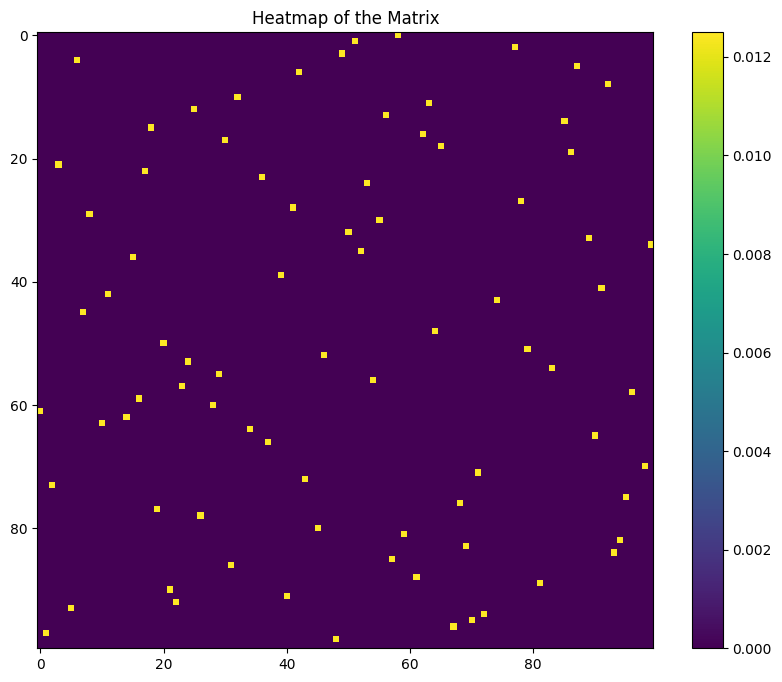

In [275]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()
